# Neural Networks and Deep Learning 
## Assignment 1 
### Neural Network on MNIST dataset
#### Harishankar S Kumar
TVE19CS034
Roll no 34

Neural network has variable number of layers layers and neurons in each layer
Uses Cross entropy Loss function with ADAM Optimization


In [1]:
#import 

import numpy as np 
import matplotlib.pyplot as plt
import time

# To convert labels into 1 hot format
from tensorflow.keras.utils import to_categorical

# dataset 
from tensorflow.keras.datasets import mnist


# Getting the mnist dataset from keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# checking if the dataset is properly define
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)



2022-02-19 23:19:52.953496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-19 23:19:52.953524: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


We can check some of the images: 

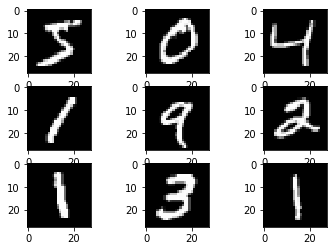

In [2]:
# plot first few images
fig = plt.figure()
fig.patch.set_facecolor('white')
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

Converting input images and labels into a more usable format for the classifier

Converting labels into one-hot format

Flattening training and test data into a single array of numbers

In [3]:
x_train_flat = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test_flat = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

print(x_test_flat.shape)
print(x_train_flat.shape)

(10000, 784)
(60000, 784)


In [4]:
# We need to turn the digits into one hot format / do more work to make the error calculation work with this
print(y_train[0:5])

# Convert y_train into one-hot format
temp = []
for i in range(len(y_train)):
    temp.append(to_categorical(y_train[i], num_classes=10))
y_train = np.array(temp)# Convert y_test into one-hot format

temp = []
for i in range(len(y_test)):    
    temp.append(to_categorical(y_test[i], num_classes=10))
y_test = np.array(temp)

print(y_train[0:5])


[5 0 4 1 9]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


So now the data is ready

### NN class outline:

1. Activation Functions and derivatives
	1. Sigmoid 
	1. Softmax 
	1. RELU 
	1. Tanh
1. parameter Initialization
	1. Create NN object
	1. Initialize weights
	1. Initialize Biases
1. Loss calculation
	1. Cross entropy Loss
	1. ADAM
1. Derivatives of activations and weights
1. Update weights



### Activation functions and their derivatives

In [5]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    return( 1 / (1 + np.exp(-x)))


def d_sigmoid(x):
    """
    Compute the derivative of sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- d ( sigmoid(x) ) /dx
    """
    return(np.exp(-x))/((np.exp(-x)+1)**2)


def softmax(x):
    """
    Compute softmax of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- A scalar or numpy array of any size.
    """
    exps = np.exp(x - x.max())
    return(exps / np.sum(exps, axis=0))


def d_softmax(x):
    exps = np.exp(x - x.max())
    return(exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0)))


def relu(x):
    """
    Compute relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- A scalar or numpy array of any size.
    """
    return(np.maximum(0,x))


def d_relu(x):
    return(1 * (x > 0))


def get_activation_id(x):
    activations = {
       "relu": 0,
       "sigmoid": 1,
       "softmax": 2,
    }
    
    try:
        id = activations[x]
    except:
        print(" >! " + x + " is not a valid activation function")
        id = -1
    return(id)
    

def activate(x, id):
    activations = {
       0: relu,
       1: sigmoid,
       2: softmax,
    }
    try:
        return(activations[id](x) )
    except:
        print(" >! " + id + " is not a valid activation function")
        quit()


def d_activate(x, id):
    activations = {
       0: d_relu,
       1: d_sigmoid,
       2: d_softmax,
    }
    try:
        return(activations[id](x))
    except:
        print(" >! " + id + " is not a valid activation function")
        quit()


def cross_entropy(pred, real):
    # cross entropy
    # cost = (1/-m)*(np.dot(Y, np.log(A.T)) + np.dot((1-Y), np.log((1-A).T))) 
    # For cross entropy with softmax, there is no dz3 and finding derivative of softmax
    # Outer layer section
    # https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples


### Neural Network Class

In [6]:
class NeuralNetwork:
	def __init__(self, layer_sizes, epochs = 10, l_rate = 0.001, activations = [], adam_m1 = 0.9, adam_m2 = 0.999, minibatch_size = 1):
		self.number_of_layers = 0
		self.input_layer_size = 0
		self.output_layer_size = 0
		self.minibatch_size = 0
		self.hidden_layer_sizes = [] 
		self.params = {}
		self.activation_ids = []
		self.adam_t = 0

		self.number_of_layers = len(layer_sizes)
		self.params = self.initialize_params(layer_sizes)
		self.epochs = epochs
		self.l_rate = l_rate
		if(len(activations) != len(layer_sizes) - 1):
			print(" Not the correct no of activation functions")
			quit()
		for i in activations:
			self.activation_ids.append(get_activation_id(i))
		self.adam_m1 = adam_m1
		self.adam_m2 = adam_m2
		self.adam_t = 0
		self.minibatch_size = minibatch_size
		self.epsilon = 0.001


	def initialize_params(self, sizes):
		self.input_layer_size = sizes[0]
		for i in sizes[ 1 : len(sizes)-1 ]:
			self.hidden_layer_sizes.append(i)
		self.output_layer_size =sizes[-1]

		params = {
			'W1':np.random.randn(self.hidden_layer_sizes[0], self.input_layer_size) * np.sqrt(1. / self.hidden_layer_sizes[0]**2),
			'W'+str(self.number_of_layers-1):np.random.randn(self.output_layer_size, self.hidden_layer_sizes[-1]) * np.sqrt(1. / self.output_layer_size*5),
			'Adam_s1': np.zeros((self.hidden_layer_sizes[0], self.input_layer_size)),
			'Adam_r1': np.zeros((self.hidden_layer_sizes[0], self.input_layer_size)),
			'Adam_s' + str(self.number_of_layers-1): np.zeros((self.output_layer_size, self.hidden_layer_sizes[-1])),
			'Adam_r' + str(self.number_of_layers-1): np.zeros((self.output_layer_size, self.hidden_layer_sizes[-1])),
		}


		if(self.number_of_layers > 3):
			temp_key = 'W'
			for i in range(0, self.number_of_layers - 3):
				params[temp_key + str(i+2)] = np.random.randn(self.hidden_layer_sizes[i+1], self.hidden_layer_sizes[i]) * np.sqrt(1. / self.hidden_layer_sizes[i+1]*5)
				params['Adam_s' + str(i+2)]: np.zeros((self.hidden_layer_sizes[i+1], self.hidden_layer_sizes[i]))
				params['Adam_r' + str(i+2)]: np.zeros((self.hidden_layer_sizes[i+1], self.hidden_layer_sizes[i]))
		return params


	def gradient_descent(self):
		pass 


	def update_weights(self, delta_w):
		'''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.
        '''
		for key, value in delta_w.items():
			self.params[key] -= self.l_rate * value


	def forward_prop(self, x_train):
		params = self.params

		# input layer activations becomes sample
		params['A0'] = x_train

		# input layer to hidden layer 1
		# params['Z1'] = np.dot(params["W1"], params['A0'])
		# params['A1'] = self.sigmoid(params['Z1'])

		# a = 'A'
		# z = 'Z'
		# w = 'W'

		for i in range(1, self.number_of_layers):
			params['Z' + str(i)] = np.dot(params["W"+str(i)], params['A' + str(i-1)])
			params['A' + str(i)] = activate(params['Z' + str(i)], self.activation_ids[i-1])

		return params['A'+str(self.number_of_layers-1)]


	def back_prop(self, y_train, output):
		'''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
		params = self.params
		change_w = {}

		# Calculate final layer update

		# error = 2 * (output - y_train) / output.shape[0] * d_activate(params['Z'+str(self.number_of_layers - 1)], self.activation_ids[-1])
		self.adam_t += 1 
		error = cross_entropy(output, y_train)
		change_w['W' + str(self.number_of_layers - 1)] = np.outer(error, params['A' + str(self.number_of_layers - 2)])
		# print(np.sum(change_w['W' + str(self.number_of_layers - 1)], axis=0) / change_w['W' + str(self.number_of_layers - 1)].shape[0])

	
		# ADAM
		# params['Adam_s'+str(self.number_of_layers - 1)] = (self.adam_m1*params['Adam_s'+str(self.number_of_layers - 1)].T + (1 - self.adam_m1)*error).T
		# params['Adam_r'+str(self.number_of_layers - 1)] = (self.adam_m2*params['Adam_r'+str(self.number_of_layers - 1)].T + (1 - self.adam_m2)*np.multiply(error, error)).T
		# # params['Adam_s'+str(self.number_of_layers - 1)] = self.adam_m1*params['Adam_s'+str(self.number_of_layers - 1)] + (1 - self.adam_m1)*np.tile(error, (params['Adam_s'+str(self.number_of_layers - 1)].shape[1], 1 )).T
		# # params['Adam_r'+str(self.number_of_layers - 1)] = self.adam_m2*params['Adam_r'+str(self.number_of_layers - 1)] + (1 - self.adam_m2)*np.tile(np.outer(error, error), (params['Adam_'+str(self.number_of_layers - 1)].shape[1], 1 )).T
		# as_hat = params['Adam_s'+str(self.number_of_layers - 1)] / (1 - self.adam_m1**self.adam_t)
		# ar_hat = params['Adam_r'+str(self.number_of_layers - 1)] / (1 - self.adam_m2**self.adam_t)
		# change_w['W' + str(self.number_of_layers - 1)] = np.divide(as_hat, (np.sqrt(ar_hat) + self.epsilon))


		# print(error.shape)
		# print(params['A' + str(self.number_of_layers - 1)].shape)

		for i in range(self.number_of_layers - 2, 0):
			# Calculate Wi update
			error = np.dot(params['W'+str(i+1)].T, error) * d_activate(params['Z'+str(i)], self.activation_ids[i])
			# print(params['w' + str(i+1)].shape)
			change_w['W'+str(i)] = np.outer(error, params['A'+str(i-1)])
			# print(np.sum(change_w['W' + str(i)], axis=0) / change_w['W' + str(i)].shape[0])
			# ADAM
			# params['Adam_s'+str(i)] = self.adam_m1*params['Adam_s'+str(i)] + (1 - self.adam_m1)*np.repeat(error, repeats= params['Adam_s'+str(i)].shape[1], axis=1)
			# params['Adam_r'+str(i)] = self.adam_m2*params['Adam_r'+str(i)] + (1 - self.adam_m2)*np.repeat(np.outer(error, error), repeats= params['Adam_s'+str(i)].shape[1], axis=1)
			# as_hat = params['Adam_s'+str(i)] / (1 - self.adam_m1**self.adam_t)
			# ar_hat = params['Adam_r'+str(i)] / (1 - self.adam_m2**self.adam_t)
			# change_w['W' + str(i)] = np.divide(as_hat, (np.sqrt(ar_hat) + self.epsilon))


		# # Calculate W1 update
		# error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
		# change_w['W1'] = np.outer(error, params['A0'])

		return change_w


	def compute_accuracy(self, x_val, y_val):
		'''
			This function does a forward pass of x, then checks if the indices
			of the maximum value in the output equals the indices in the label
			y. Then it sums over each prediction and calculates the accuracy.
		'''
		predictions = []

		for x, y in zip(x_val, y_val):
			output = self.forward_prop(x)
			pred = np.argmax(output)
			predictions.append(pred == np.argmax(y))

		return np.mean(predictions)


	def train(self, x_train, y_train, x_val, y_val):
		minibatch_size = self.minibatch_size
		start_time = time.time()
		accuracy = []
		for iteration in range(self.epochs):
			m_b_s = 0
			m_b_e = minibatch_size
			for i2 in range(x_train.shape[0]//minibatch_size+1):
				for x,y in zip(x_train[m_b_s:min(x_train.shape[0] - m_b_s, m_b_e)], y_train[m_b_s:min(y_train.shape[0] - m_b_s, m_b_e)]):
					output = self.forward_prop(x)
					changes_to_w = self.back_prop(y, output)
					self.update_weights(changes_to_w)
				m_b_s = m_b_e
				m_b_e += minibatch_size
				# print(str(m_b_s) + " " + str(m_b_e))
			accuracy.append(self.compute_accuracy(x_val, y_val))
			print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
				iteration+1, time.time() - start_time, accuracy[-1] * 100
			))
		return(accuracy)


Now Running the Program

In [7]:

dnn = NeuralNetwork(layer_sizes = [784, 40, 20, 10], activations = ["sigmoid", "sigmoid", "softmax"], epochs=100, minibatch_size=10000)
accuracies = dnn.train(x_train_flat, y_train, x_test_flat, y_test)[:]
# Had issue where the data from this object was also in the new object
del dnn

Epoch: 1, Time Spent: 2.97s, Accuracy: 14.13%
Epoch: 2, Time Spent: 5.83s, Accuracy: 18.95%
Epoch: 3, Time Spent: 8.69s, Accuracy: 20.34%
Epoch: 4, Time Spent: 11.62s, Accuracy: 21.39%
Epoch: 5, Time Spent: 14.48s, Accuracy: 22.47%
Epoch: 6, Time Spent: 17.38s, Accuracy: 23.43%
Epoch: 7, Time Spent: 20.26s, Accuracy: 24.37%
Epoch: 8, Time Spent: 22.64s, Accuracy: 25.63%
Epoch: 9, Time Spent: 25.26s, Accuracy: 26.51%
Epoch: 10, Time Spent: 28.22s, Accuracy: 27.26%
Epoch: 11, Time Spent: 31.21s, Accuracy: 27.90%
Epoch: 12, Time Spent: 34.15s, Accuracy: 28.89%
Epoch: 13, Time Spent: 37.11s, Accuracy: 29.61%
Epoch: 14, Time Spent: 39.98s, Accuracy: 30.45%
Epoch: 15, Time Spent: 42.92s, Accuracy: 31.32%
Epoch: 16, Time Spent: 45.85s, Accuracy: 32.00%
Epoch: 17, Time Spent: 48.75s, Accuracy: 32.77%
Epoch: 18, Time Spent: 51.68s, Accuracy: 33.21%
Epoch: 19, Time Spent: 54.59s, Accuracy: 33.85%
Epoch: 20, Time Spent: 57.56s, Accuracy: 34.30%
Epoch: 21, Time Spent: 60.47s, Accuracy: 34.62%
Epoc

Plotting graph :

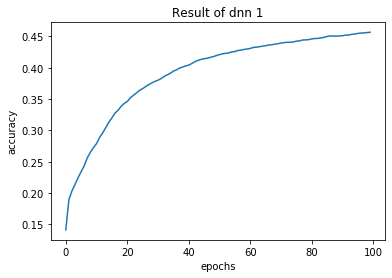

In [8]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([i for i in range(100)], accuracies)
# naming the x axis
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('accuracy')
 
# giving a title to my graph
plt.title('Result of dnn 1')
 
# function to show the plot
plt.show()

Creating a new ANN

Epoch: 1, Time Spent: 9.81s, Accuracy: 12.52%
Epoch: 2, Time Spent: 20.21s, Accuracy: 14.14%
Epoch: 3, Time Spent: 30.07s, Accuracy: 16.02%
Epoch: 4, Time Spent: 40.16s, Accuracy: 18.12%
Epoch: 5, Time Spent: 50.75s, Accuracy: 19.89%
Epoch: 6, Time Spent: 60.66s, Accuracy: 21.74%
Epoch: 7, Time Spent: 70.09s, Accuracy: 23.50%
Epoch: 8, Time Spent: 79.08s, Accuracy: 25.51%
Epoch: 9, Time Spent: 89.51s, Accuracy: 27.37%
Epoch: 10, Time Spent: 99.26s, Accuracy: 28.78%
Epoch: 11, Time Spent: 109.59s, Accuracy: 30.34%
Epoch: 12, Time Spent: 119.45s, Accuracy: 31.56%
Epoch: 13, Time Spent: 128.72s, Accuracy: 32.91%
Epoch: 14, Time Spent: 138.07s, Accuracy: 34.04%
Epoch: 15, Time Spent: 147.06s, Accuracy: 35.01%
Epoch: 16, Time Spent: 156.53s, Accuracy: 36.01%
Epoch: 17, Time Spent: 165.80s, Accuracy: 37.04%
Epoch: 18, Time Spent: 175.00s, Accuracy: 37.94%
Epoch: 19, Time Spent: 184.14s, Accuracy: 38.91%
Epoch: 20, Time Spent: 193.04s, Accuracy: 39.54%
Epoch: 21, Time Spent: 203.03s, Accuracy

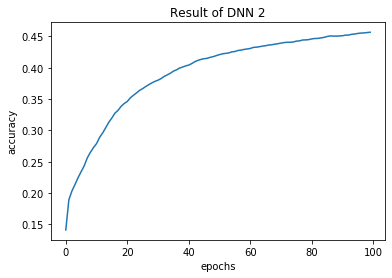

In [10]:
dnn2 = NeuralNetwork(layer_sizes = [784, 200, 100, 50, 10], activations = ["sigmoid", "sigmoid", "sigmoid",  "softmax"], epochs=100, minibatch_size=100000)
accuracies2 = dnn2.train(x_train_flat, y_train, x_test_flat, y_test)
del dnn2

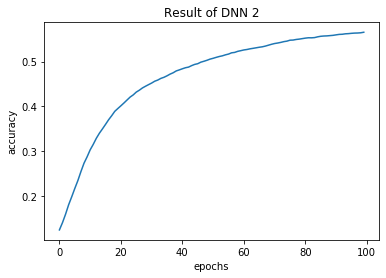

In [11]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([i for i in range(100)], accuracies2)
# naming the x axis
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('accuracy')
 
# giving a title to my graph
plt.title('Result of DNN 2')
 
# function to show the plot
plt.show()


### TODO:

1. Fix ADAM Optimization
1. Add Tanh option

# Results

2 Neural Networks were Created using a model developed from scratch, and  from the given results, 
we can see that: with the same number of passes through the dataset, 
the model with higher number of nodes was able to reach a higher accuracy than the model with lower number of nodes.

Clearly Second Model had better accuracy and is having better performance.


### Remarks

I was unable to implement the ADAM optimization on time as it was very error prone and due to a lack of time.

Tanh activation function and its derivative can be integrated later.



***

***Submitted by,***

***Harishankar S Kumar***

***TVE19CS034***

***Roll No 34***

***S5 CS***

References:

https://medium.com/analytics-vidhya/neural-network-mnist-classifier-from-scratch-using-numpy-library-94bbcfed7eae

https://www.kaggle.com/oddrationale/mnist-in-csv?select=mnist_train.csv

https://github.com/mkisantal/MNIST-from-scratch

https://mlfromscratch.com/neural-network-tutorial/#/

https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7